In [41]:
import os 
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import json

In [42]:
#sc_out = pd.DataFrame()
#for file in os.listdir('../ce_data/StatCache'):
#    x = pd.read_csv("../ce_data/StatCache/"+file)
#    x['id'] = x.index
#    x['id'] = x['id'].apply(lambda x: file[:-4] + "_" + str(x))
#    sc_out = pd.concat([x, sc_out], ignore_index=True)
#sc_out = sc_out.sort_values("id", ascending=True, ignore_index=True).fillna(0)
sc_out = pd.read_csv('../ce_data/output_512/statcache_512_olr.csv')
for i in ['32','64','128','256','512','1024','2048','4096','8192']:
    sc_out['lru_'+i] = sc_out['lru_'+i]/sc_out['total_accesses']
print(sc_out)

                         id  random_32    lru_32  random_64    lru_64  \
0       400.perlbench-41B_0   0.004097  0.002922   0.002877  0.002121   
1     400.perlbench-41B_436   0.018865  0.013493   0.012396  0.008749   
2       400.perlbench-50B_0   0.004524  0.002858   0.002693  0.001779   
3          401.bzip2-226B_0   0.057553  0.048776   0.044189  0.035407   
4         401.bzip2-226B_54   0.095998  0.086282   0.078118  0.069222   
...                     ...        ...       ...        ...       ...   
6186     657.xz_s-3167B_466   0.038392  0.028100   0.027225  0.020199   
6187     657.xz_s-3167B_574   0.042664  0.035252   0.030093  0.022492   
6188       657.xz_s-4994B_0   0.008552  0.006117   0.005317  0.003739   
6189     657.xz_s-4994B_343   0.011664  0.008036   0.007941  0.005771   
6190         657.xz_s-56B_0   0.000000  0.000000   0.000000  0.000000   

      random_128   lru_128  random_256   lru_256  random_512   lru_512  \
0       0.002266  0.001816    0.001900  0.001627 

In [43]:
cache_misses = pd.read_csv("../ce_data/output_512/dataset.csv")
# l = ['mcf' in i for i in sc_out["id"]]
for i in ['1024', '2048', '4096', '8192']:
    cache_misses[i] =  cache_misses['misses_'+i] / cache_misses['accesses_'+i]
#cache_misses = cache_misses[l]
#sc_out = sc_out[l]
print(cache_misses, sc_out)

                         id         0         1         2        3        4  \
0       400.perlbench-41B_0  50816880  17323312  11868112  7701840  3853504   
1     400.perlbench-41B_436  17361520   6023600   4203744  2591488  1828656   
2       400.perlbench-50B_0  58283520  17249296  14592592  9466576  7204896   
3          401.bzip2-226B_0   3098304   3037808   2698720  2692176  1999568   
4         401.bzip2-226B_54   1623056   1618144   1501200  1353728  1014736   
...                     ...       ...       ...       ...      ...      ...   
6186     657.xz_s-3167B_466   4869744   5968224   3301024  2821488  2218352   
6187     657.xz_s-3167B_574   4967104   7056944   3530208  2928336  2367040   
6188       657.xz_s-4994B_0  18063488  19199008   9437200  7269680  7833904   
6189     657.xz_s-4994B_343  13498912  14343616   6633152  5098416  6450640   
6190         657.xz_s-56B_0  26356736  36838224  10074240  2059088  2506384   

            5        6        7        8  ...  acce

In [45]:
# Little check
d = {}
for i,j in zip(cache_misses["id"], sc_out["id"]):
    if i != j:
        print(i,j)
    if i in d: 
        print(i)
    d[i]=1

In [46]:
from sklearn.metrics import mean_squared_error
bdf = pd.DataFrame()
for i in ['1024', '2048', '4096', '8192']:
    tmp = sc_out['lru_'+i] / sc_out['lru_512']
    # This drops na
    cms = cache_misses[tmp <= 1]
    tmp = tmp[tmp <= 1]
    c_acc_lru = mean_squared_error(tmp, cms[i])
    #c_acc_rand = mean_squared_error(o['random_'+i], cache_misses[i])
    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}')
    bdf['sc_'+i] = tmp
    bdf['cm_'+i] = cms[i]
    bdf['id'] = cms['id']
    bdf['diffs_'+i] = abs(tmp - cms[i])

Cache size 1024	: lru_mse = 0.04016108179134338
Cache size 2048	: lru_mse = 0.08260871916762032
Cache size 4096	: lru_mse = 0.09357076195162235
Cache size 8192	: lru_mse = 0.08639397608972577


In [6]:
#from sklearn.metrics import mean_squared_error, mean_absolute_error
#for i in ['1024','2048','4096','8192']:
#    tmp = sc_out['lru_'+i] * cache_misses['l1d_accesses_'+i]/cache_misses['accesses_'+i]
#    c_acc_lru = mean_squared_error(tmp, cache_misses[i])
#    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}')

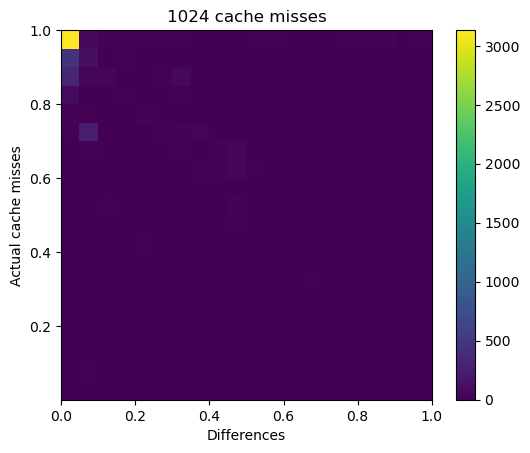

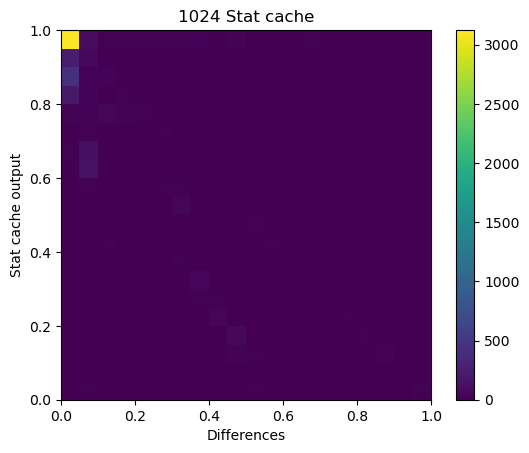

In [47]:
heatmap, xedges, yedges = np.histogram2d(bdf['diffs_1024'], bdf['cm_1024'], bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.title('1024 cache misses')
plt.xlabel('Differences')
plt.ylabel('Actual cache misses')
plt.show()
heatmap, xedges, yedges = np.histogram2d(bdf['diffs_1024'],  bdf['sc_1024'], bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.title('1024 Stat cache')
plt.ylabel('Stat cache output')
plt.xlabel('Differences')
plt.show()

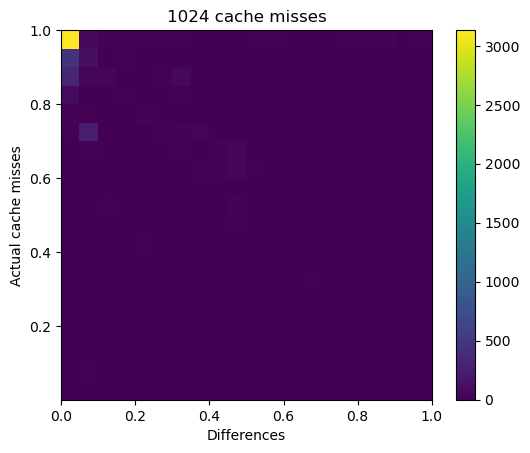

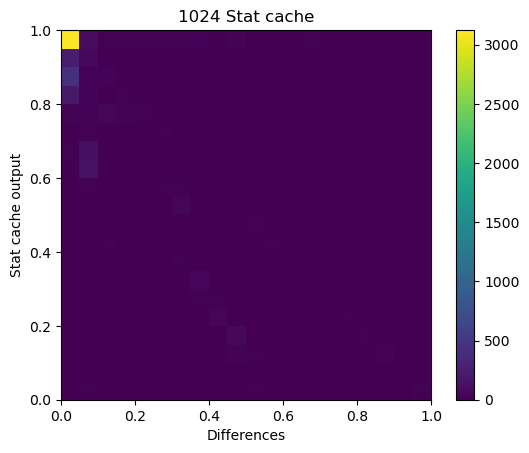

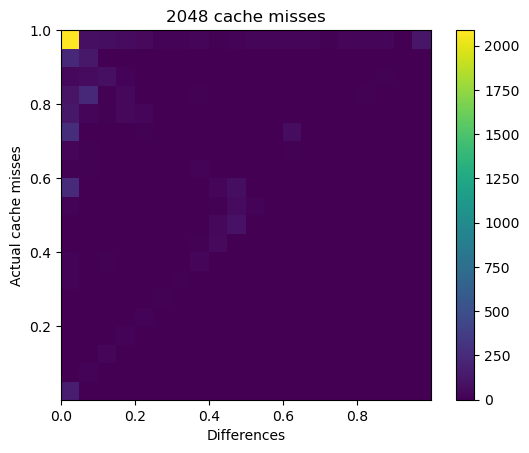

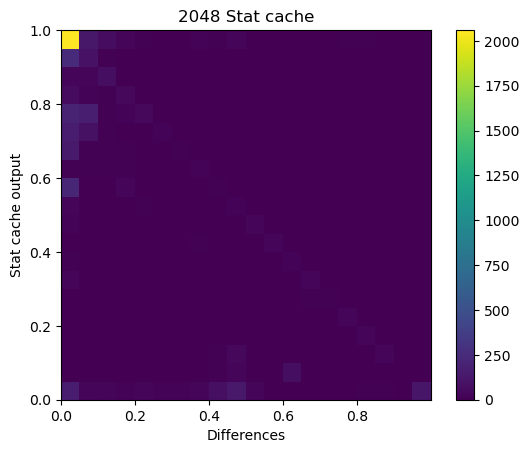

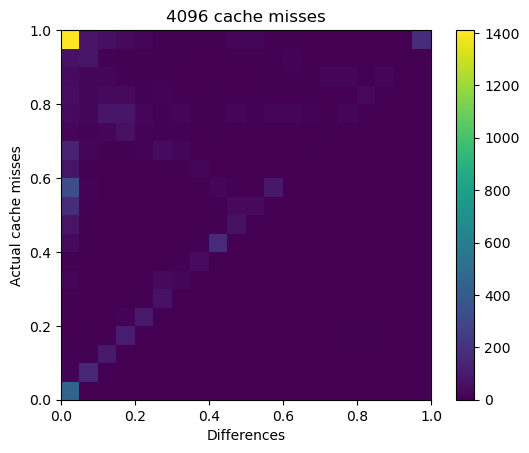

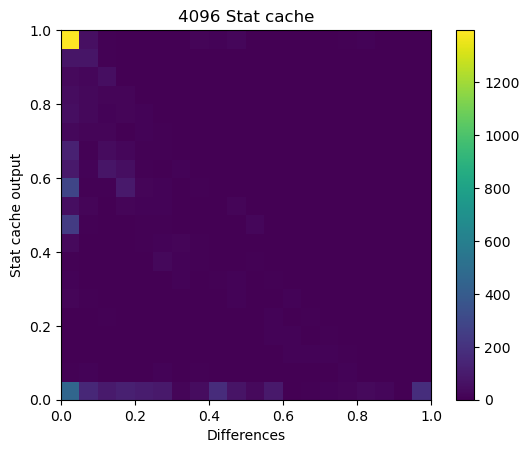

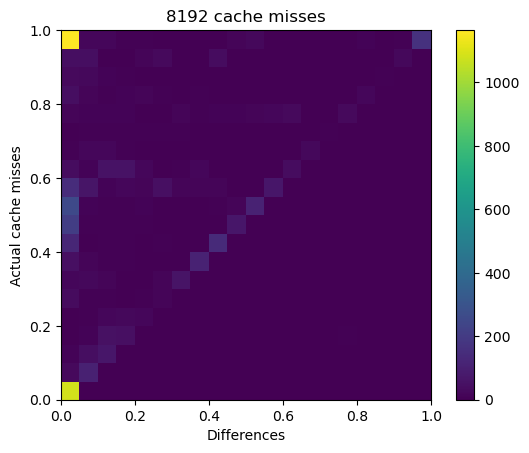

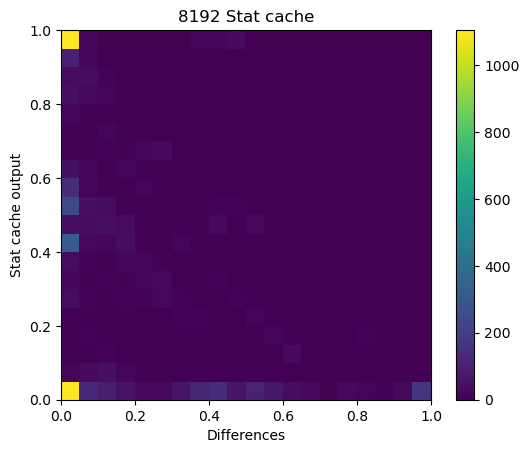

In [48]:
for i in ['1024','2048','4096','8192']:
    heatmap, xedges, yedges = np.histogram2d(bdf['diffs_'+i], bdf['cm_'+i], bins=20)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    plt.colorbar()
    plt.title(i+' cache misses')
    plt.xlabel('Differences')
    plt.ylabel('Actual cache misses')
    plt.show()
    heatmap, xedges, yedges = np.histogram2d(bdf['diffs_'+i],  bdf['sc_'+i], bins=20)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    plt.colorbar()
    plt.title(i+' Stat cache')
    plt.ylabel('Stat cache output')
    plt.xlabel('Differences')
    plt.show()

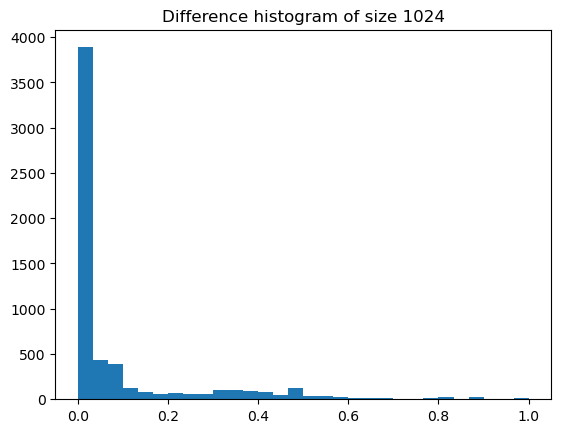

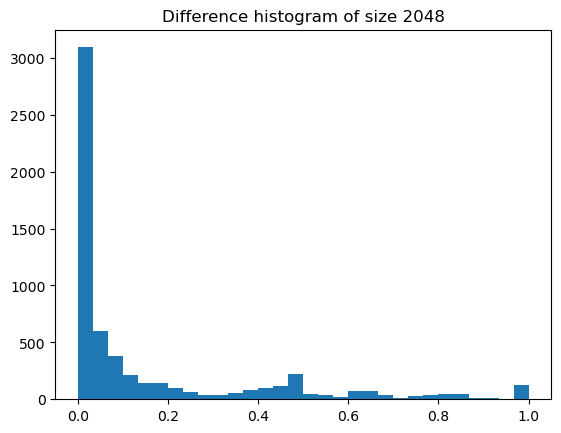

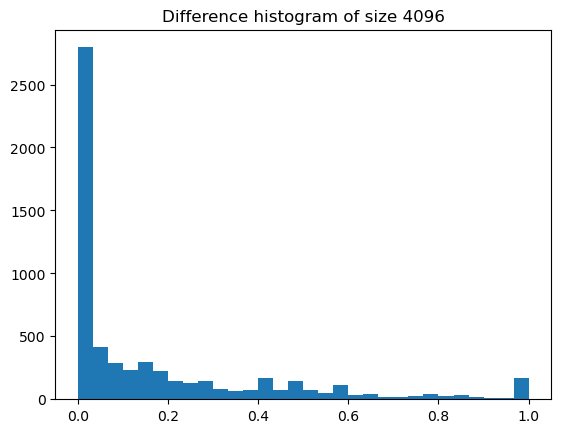

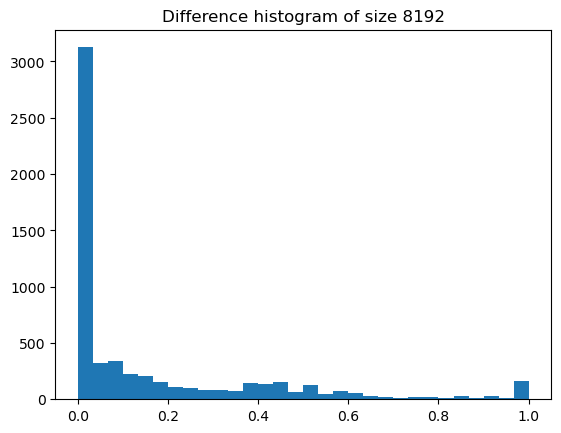

In [49]:
for i in ['1024','2048','4096','8192']:
    plt.title(f"Difference histogram of size {i}")
    plt.hist(bdf['diffs_'+i], bins =30)
    plt.show()

In [51]:
d = {}
for i in sc_out["id"]:
    ctr = 1
    while(1):
        if i[-ctr] == '_':
            break
        ctr+=1
    d[i[:-ctr]] = 1

In [52]:
for i in ['1024','2048','4096','8192']:
    c_acc_lru = mean_squared_error([0.5]*len(cache_misses), cache_misses[i])
    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}')

Cache size 1024	: lru_mse = 0.18502142115044984
Cache size 2048	: lru_mse = 0.1581590436185805
Cache size 4096	: lru_mse = 0.13392367049825069
Cache size 8192	: lru_mse = 0.13181527230699921


In [53]:
for i in ['1024','2048','4096','8192']:
    c_acc_lru = mean_squared_error(bdf[bdf['sc_'+i] < 0.6]['sc_'+i], bdf[bdf['sc_'+i] < 0.6]['cm_'+i])
    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}')

Cache size 1024	: lru_mse = 0.21862562358700824
Cache size 2048	: lru_mse = 0.23241540292811322
Cache size 4096	: lru_mse = 0.155647889194954
Cache size 8192	: lru_mse = 0.11448625289454704


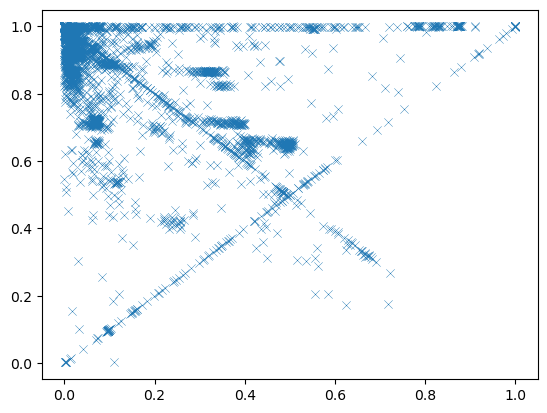

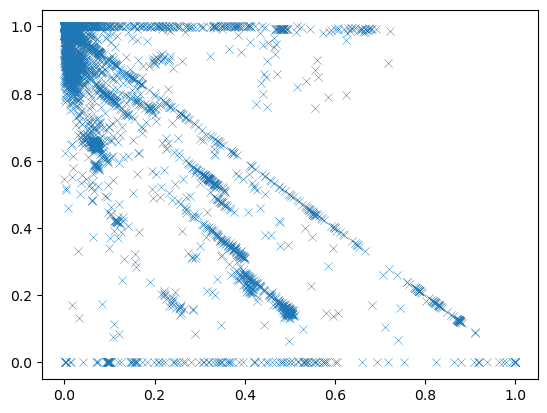

In [54]:
plt.scatter(bdf['diffs_1024'], bdf['cm_1024'], marker='x', linewidths = 0.3)
plt.show()
plt.scatter(bdf['diffs_1024'], bdf['sc_1024'], marker='x', linewidths = 0.3)
plt.show()

In [55]:
# Outputs sorted by difference for some data analysis
bdf = bdf.sort_values("diffs_1024", ascending=False)
bdf.head(15)

,sc_1024,cm_1024,id,diffs_1024,sc_2048,cm_2048,diffs_2048,sc_4096,cm_4096,diffs_4096,sc_8192,cm_8192,diffs_8192
1793,0.0,1.000000,459.GemsFDTD-1491B_43,1.000000,0.0,0.981478,0.981478,0.0,0.774982,0.774982,0.0,0.750405,0.750405
1794,0.0,1.000000,459.GemsFDTD-1491B_54,1.000000,0.0,0.978902,0.978902,0.0,0.772827,0.772827,0.0,0.750284,0.750284
1795,0.0,1.000000,459.GemsFDTD-1491B_65,1.000000,0.0,0.983027,0.983027,0.0,0.770602,0.770602,0.0,0.750330,0.750330
1796,0.0,1.000000,459.GemsFDTD-1491B_76,1.000000,0.0,0.982563,0.982563,0.0,0.770972,0.770972,0.0,0.750265,0.750265
1797,0.0,1.000000,459.GemsFDTD-1491B_87,1.000000,0.0,0.981166,0.981166,0.0,0.773199,0.773199,0.0,0.750303,0.750303
1798,0.0,1.000000,459.GemsFDTD-1491B_98,1.000000,0.0,0.979937,0.979937,0.0,0.774200,0.774200,0.0,0.750268,0.750268
1799,0.0,1.000000,459.GemsFDTD-1491B_109,1.000000,0.0,0.980226,0.980226,0.0,0.773210,0.773210,0.0,0.750266,0.750266
4190,0.0,1.000000,605.mcf_s-484B_584,1.000000,0.0,0.999998,0.999998,0.0,0.992469,0.992469,0.0,0.938975,0.938975
1790,0.0,1.000000,459.GemsFDTD-1491B_10,1.000000,0.0,0.981309,0.981309,0.0,0.770218,0.770218,0.0,0.750280,0.750280
1791,0.0,1.000000,459.GemsFDTD-1491B_21,1.000000,0.0,0.979655,0.979655,0.0,0.772663,0.772663,0.0,0.750271,0.750271
